In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
tf.keras.backend.set_image_data_format("channels_last")


2024-05-26 13:17:01.192136: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 13:17:01.268721: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# Path to the data directory
data_dir = Path("./captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'2', 'y', '7', 'e', 'x', 'f', 'd', '4', 'g', '3', 'p', '8', 'm', '6', 'c', 'w', 'n', 'b', '5'}


In [4]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), num_oov_indices=0, mask_token=None, invert=True
)

2024-05-26 13:17:04.489689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 13:17:04.736241: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1124 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:65:00.0, compute capability: 8.6
2024-05-26 13:17:04.736862: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11203 MB memory:  -> device: 1, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:b3:00.0, compute capability: 6.1


In [5]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # _, ax = plt.subplots(4, 1, figsize=(10, 5))
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    # for ii in range(4):
    #     print(labels[ii])
    #     print(images[ii])
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

In [6]:
# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

In [7]:
x_train[:5]

array(['captcha_images_v2/6wg4n.png', 'captcha_images_v2/g7fmc.png',
       'captcha_images_v2/y2436.png', 'captcha_images_v2/x37bf.png',
       'captcha_images_v2/3nfdn.png'], dtype='<U27')

In [8]:
y_train[:5]

array(['nfbg8', 'e25xg', '6c3n6', 'yd755', 'mmg2m'], dtype='<U5')

In [7]:
def encode_single_sample(img_path, label):
# def encode_single_sample(img_path):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # label = char_to_num(tf.strings.unicode_split(os.basename(img_path, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    print(img_path)
    print(label)
    return {"image": img, "label": label}

In [8]:
# tf.data.experimental.enable_debug_mode()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

Tensor("args_0:0", shape=(), dtype=string)
Tensor("string_lookup/Identity:0", shape=(None,), dtype=int64)
Tensor("args_0:0", shape=(), dtype=string)
Tensor("string_lookup/Identity:0", shape=(None,), dtype=int64)


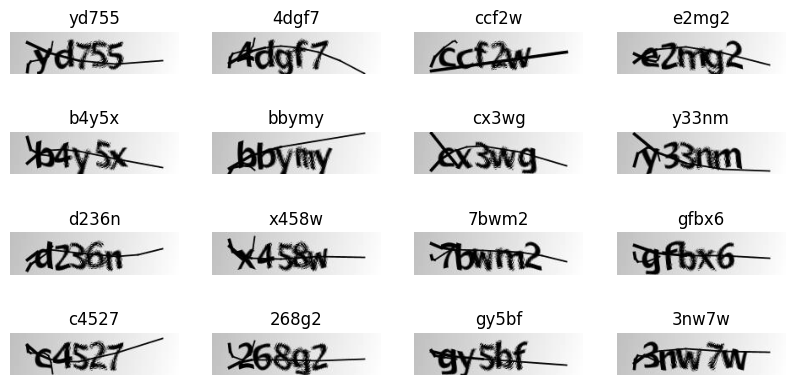

In [9]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [10]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [11]:
def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    print(input_img.shape)
    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
        data_format='channels_last'
    )(input_img)
    print(x.shape)
    x = layers.MaxPooling2D((2, 2), strides=(2,2), padding='same', name="pool1", data_format='channels_last')(x)
    print(x.shape)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
        data_format='channels_last',
    )(x)
    print(x.shape)
    x = layers.MaxPooling2D((2, 2), strides=(2,2), padding='valid', name="pool2", data_format='channels_last')(x)
    print(x.shape)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    print(x.shape)
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    print(new_shape)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

In [12]:
# Get the model
model = build_model()
model.summary()

(None, 200, 50, 1)
(None, 200, 50, 32)
(None, 100, 25, 32)
(None, 100, 25, 64)
(None, 50, 12, 64)
(None, 50, 12, 64)
(50, 768)
Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                           

In [13]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100


2024-05-26 13:17:31.322994: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8907
2024-05-26 13:17:31.412137: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-26 13:17:31.536487: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


59/59 [==============================] - 9s 59ms/step - loss: 22.3796 - val_loss: 16.3074
Epoch 2/100
59/59 [==============================] - 2s 35ms/step - loss: 16.3427 - val_loss: 16.3121
Epoch 3/100
59/59 [==============================] - 2s 35ms/step - loss: 16.3376 - val_loss: 16.3105
Epoch 4/100
59/59 [==============================] - 2s 35ms/step - loss: 16.3335 - val_loss: 16.3146
Epoch 5/100
59/59 [==============================] - 2s 35ms/step - loss: 16.3332 - val_loss: 16.3150
Epoch 6/100
59/59 [==============================] - 2s 35ms/step - loss: 16.3211 - val_loss: 16.3011
Epoch 7/100
59/59 [==============================] - 2s 36ms/step - loss: 16.3104 - val_loss: 16.2913
Epoch 8/100
59/59 [==============================] - 2s 36ms/step - loss: 16.2926 - val_loss: 16.2237
Epoch 9/100
59/59 [==============================] - 2s 36ms/step - loss: 16.2221 - val_loss: 16.0587
Epoch 10/100
59/59 [==============================] - 2s 35ms/step - loss: 15.9154 - val_loss:

In [14]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

In [15]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        #print(res)
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

1/1 [==============================] - 1s 1s/step


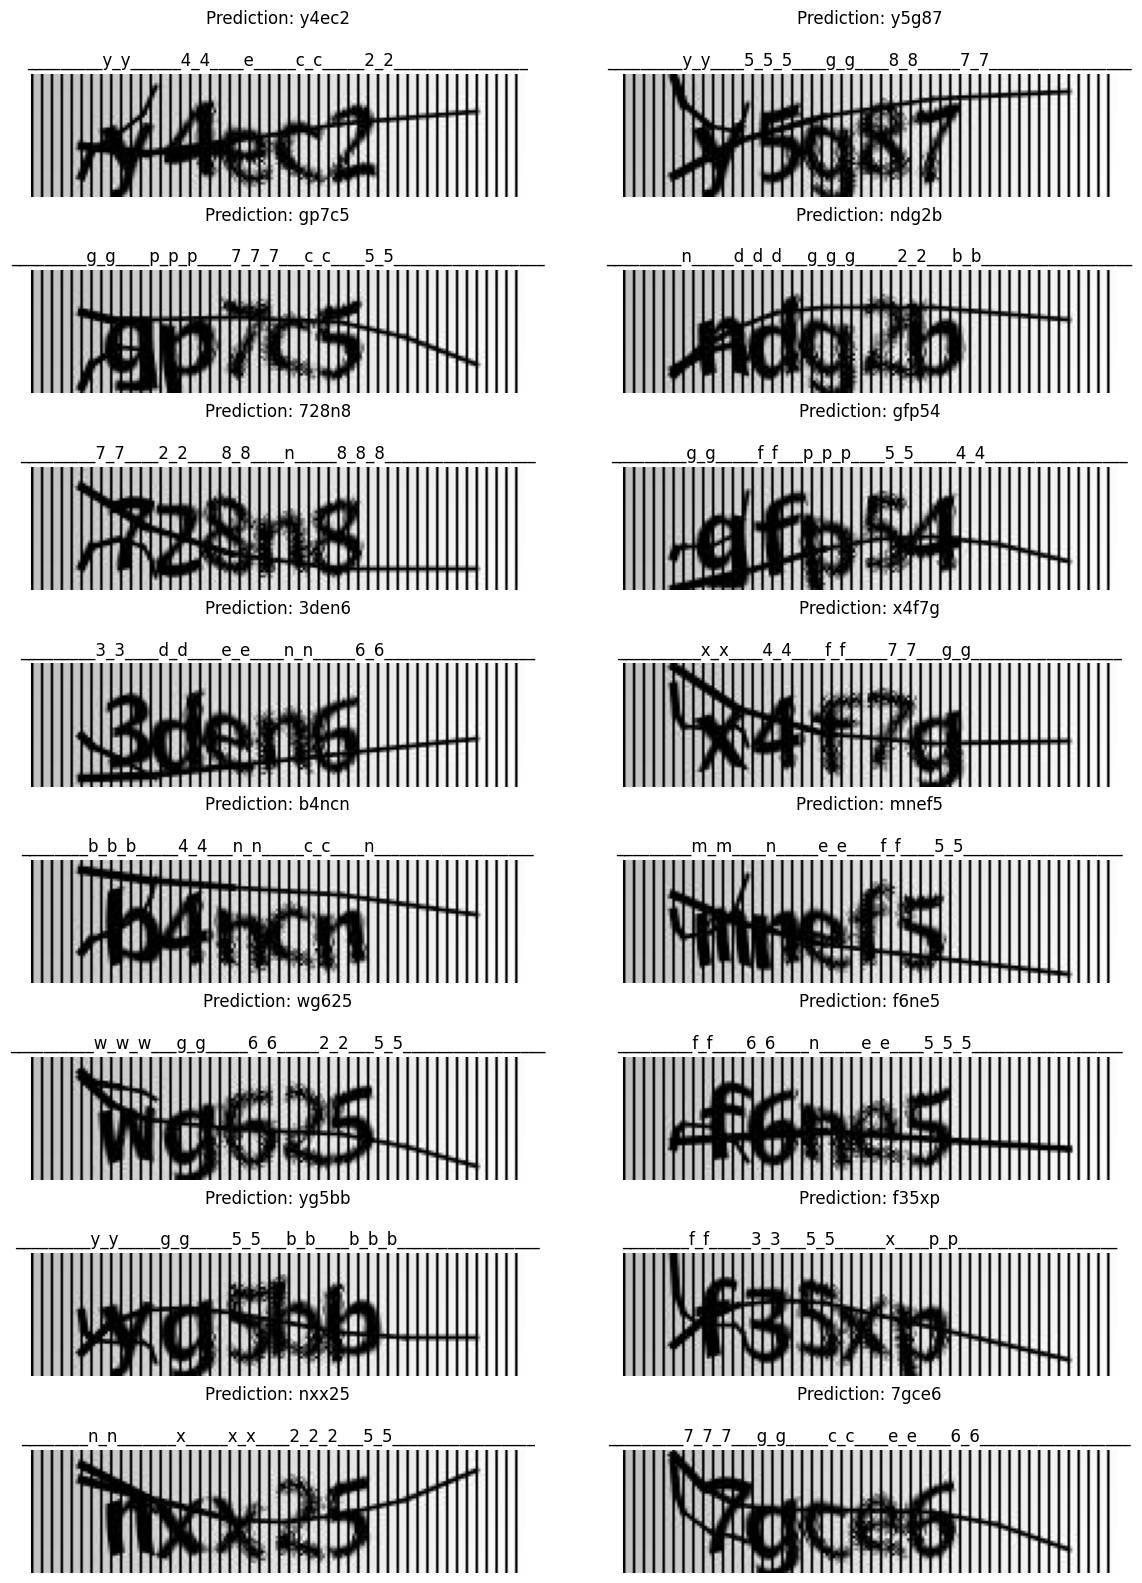

In [17]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    
    #for pred in preds:
    #    print([ tf.strings.reduce_join(num_to_char(np.array([np.argmax(a)]))).numpy().decode("utf-8") for a in np.array(pred)])
    
    pred_texts = decode_batch_predictions(preds)
    #print([ tf.strings.reduce_join(num_to_char(np.array([np.argmax(a)]))).numpy().decode("utf-8") for a in np.array(pred)])
    #print(res)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(8, 2, figsize=(14, 20))
    for i in range(len(pred_texts)):
        textVector = [ tf.strings.reduce_join(num_to_char(np.array([np.argmax(a)]))).numpy().decode("utf-8").replace("[UNK]","") for a in np.array(preds[i])]
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        #print(np.array(img).shape)
        
        for indice in range(50):
            img[0:len(img), indice*4:indice*4+1] = 0
            
        title = f"Prediction: {pred_texts[i]}\n\n{'_'.join(textVector)}"
        ax[i // 2, i % 2].imshow(img, cmap="gray")
        ax[i // 2, i % 2].set_title(title)
        ax[i // 2, i % 2].axis("off")
        
plt.show()